In [1]:
%matplotlib inline
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm import *

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the cell below.  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

In [2]:
def points_for_calibration(images_pattern='camera_cal/calibration*.jpg', nx=9, ny=6):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    for name in tqdm(glob.glob(images_pattern)):
        # Convert to grayscale
        img = cv2.imread(name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, append points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.

In [3]:
import pickle

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

objpoints, imgpoints = points_for_calibration()

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration.p", "wb"))

100%|██████████████████████████████████████████| 20/20 [00:05<00:00,  3.78it/s]


I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

In [4]:
def display_images(img1, img2, title1='Original image', 
                   title2='Modified image', filename=None, cmap=None):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2, fontsize=30)

    if filename:
        plt.savefig(filename)

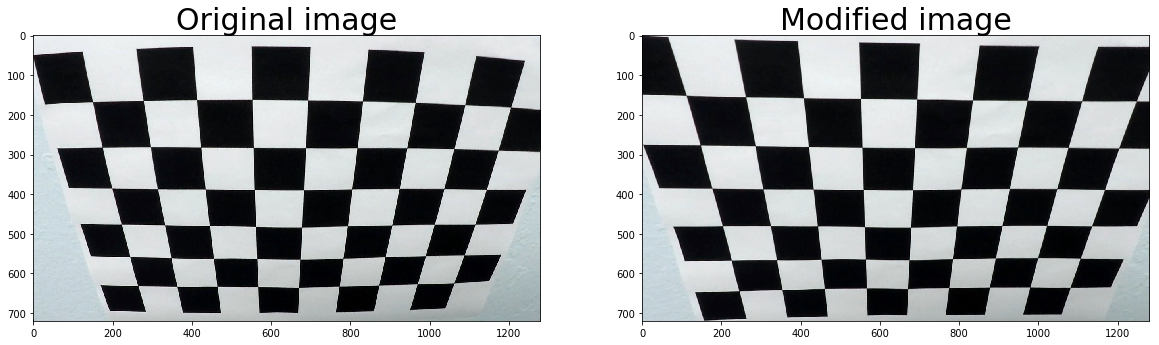

In [294]:
img = cv2.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
# Visualize undistortion
display_images(img, undistorted, filename='output_images/original_undistorted.png')

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:
![alt text][image2]

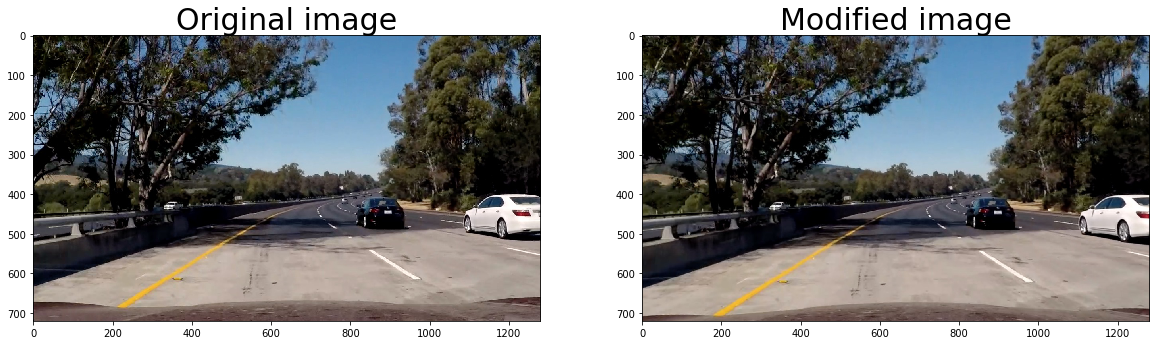

In [5]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

display_images(img, undistorted, filename='output_images/test_original_undistorted.png')

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color, gradient (direction and magnitude) thresholds and [morphological transformations](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) to generate a binary image. The threshold functions are defined below.

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        deriv = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        deriv = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    deriv = np.absolute(deriv)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    deriv = ((deriv / np.max(deriv)) * 255).astype(np.uint8)
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(deriv)
    grad_binary[(deriv > thresh[0]) & (deriv < thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    mag = np.sqrt((np.square(sobelx) + np.square(sobely)))
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    mag = ((mag / np.max(mag)) * 255).astype(np.uint8)
    
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(mag)
    mag_binary[(mag > mag_thresh[0]) & (mag < mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(arctan)
    dir_binary[(arctan > thresh[0]) & (arctan < thresh[1])] = 1
    return dir_binary

def color_threshold(img, thresh=(0, 255)):
    
    # 1) Convert to HLS colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # 5) Create a binary mask where color thresholds are met
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh[0]) & (s_channel < thresh[1])] = 1
    
    return s_binary

Here's an example of my output for this step. We can see that the morphological transformations do a good job in removing "noise" and making lane lines more clear. We define a function `binary_image` to reuse this strategy in the pipeline.

In [7]:
def binary_image(img):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10,150))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(10,150))
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30,200))
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.2))
    color_binary = color_threshold(img, thresh=(180,255))

    binary = np.zeros_like(color_binary)
    binary[(gradx == 1) & (grady == 1) | (color_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # morphological transformations
    #kernel = np.ones((3,3),np.uint8)
    #binary = cv2.dilate(binary, kernel, iterations=1)
    #binary = cv2.erode(binary, kernel, iterations=3)
    #binary = cv2.dilate(binary, kernel, iterations=2)
    return binary

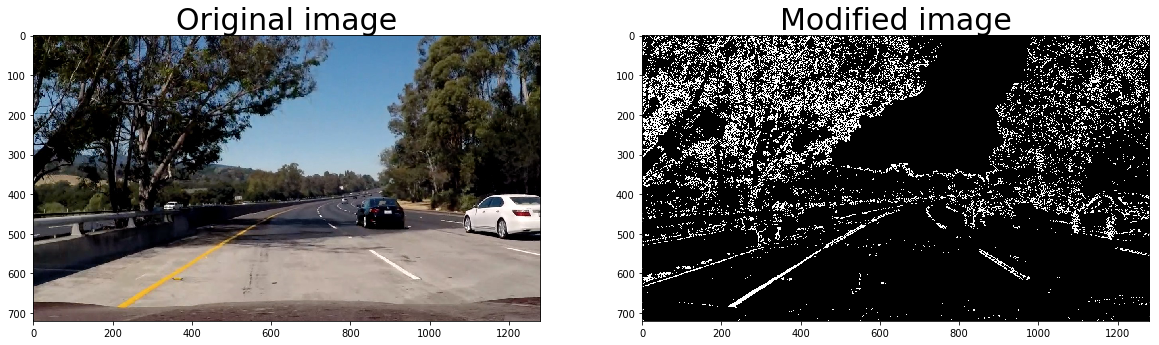

In [8]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary = binary_image(img)
display_images(img, binary, cmap='gray')

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `birds_eye()` defined below.  The `birds_eye()` function takes as inputs an image (`img`), as well as the camera matrix (`mtx`) and distortion coefficients (`dist`) points.  I chose birds_eye hardcode the source and destination points in the following manner:

```
src = np.array([[img.shape[1]/6, img.shape[0]],
                [img.shape[1]/2 - 45, img.shape[0]/1.6],
                [img.shape[1]/2 + 50, img.shape[0]/1.6],
                [img.shape[1] - 170, img.shape[0]]], np.float32)
    
dst = np.array([[src[0,0],img.shape[0]], [src[0,0],0],
                [src[-1,0],0], [src[-1,0],img.shape[0]]], np.float32)
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 213, 720      | 213, 720      | 
| 595, 450      | 213, 0        |
| 690, 450      | 1110, 0       |
| 1110, 720     | 1110, 720     |

In [34]:
def birds_eye(img, mtx, dist, show_lines=False):
    
    # 1) Undistort using mtx and dist
    undistorted = cv2.undistort(img, mtx, dist)
    
    src = np.array([[img.shape[1]/6 - 10, img.shape[0]],
                [img.shape[1]/2 - 48, img.shape[0]/1.6],
                [img.shape[1]/2 + 50, img.shape[0]/1.6],
                [img.shape[1] - 160, img.shape[0]]], np.float32)
    
    dst = np.array([[src[0,0] + 120, img.shape[0]],
                    [src[0,0] + 120, 0],
                    [src[-1,0] - 120, 0],
                    [src[-1,0] - 120, img.shape[0]]], np.float32)
    
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undistorted, M, undistorted.shape[:2][::-1])
    
    if show_lines:
        if len(warped.shape) == 2:
            warped = np.dstack((warped, warped, warped))

        if np.max(warped) > 1:
            max_color = 255
        else:
            max_color = 1

        cv2.polylines(img, np.array([src], np.int32), True, (max_color,0,0), 3)
        cv2.polylines(warped, np.array([dst], np.int32), True, (max_color,0,0), 3)
    
    return warped, M

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

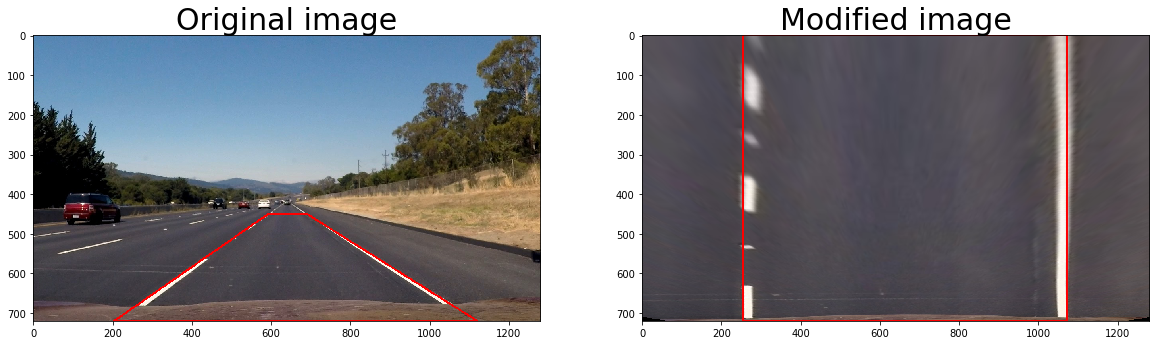

In [31]:
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped, _ = birds_eye(img, mtx, dist, show_lines=True)
display_images(img, warped, filename='output_images/birds_eye.png')

Let's see how this works on an warped binary image.

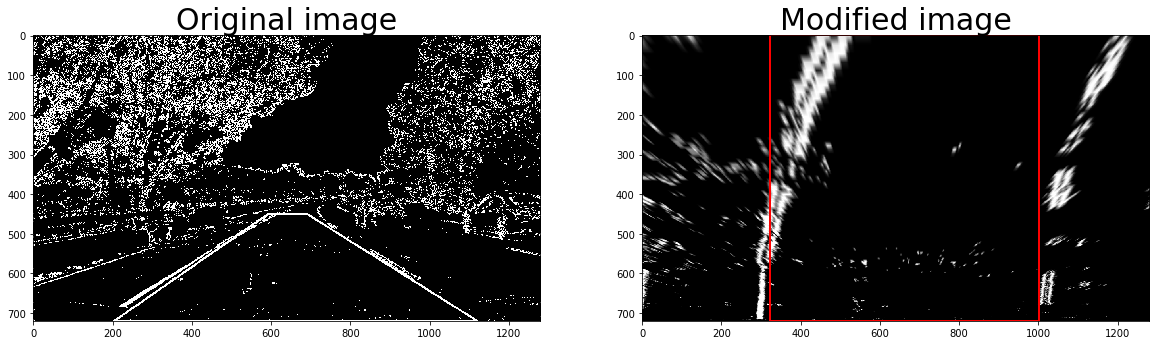

In [35]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary = binary_image(img)
binary_warped, _ = birds_eye(binary, mtx, dist, show_lines=True)
#plt.imshow(warped)
display_images(binary, binary_warped, cmap='gray')

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

In [11]:
def lane_bases(binary_image):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_image[binary_image.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

def apply_constraints(left_fit, right_fit, 
                      left_lane_inds, right_lane_inds, 
                      left_base, right_base, max_y):
    
    if left_fit[0] < 0 and right_fit[0] > 0 or left_fit[0] > 0 and right_fit[0] < 0:
        # print('Lane detection discarded: coefficients with inverted signals')
        # choose the lane with more information as the fit for the two lanes
        if len(left_lane_inds) > len(right_lane_inds):
            right_fit[:2] = left_fit[:2]
            right_fit[-1] = right_base - right_fit[0]*(max_y)**2 - right_fit[1]*max_y
        else:
            left_fit[:2] = right_fit[:2]
            left_fit[-1] = left_base - left_fit[0]*(max_y)**2 - left_fit[1]*max_y
        
    max_lane_width = 800
    min_lane_width = 600
    left_fitx = left_fit[0]*max_y**2 + left_fit[1]*max_y + left_fit[2]
    right_fitx = right_fit[0]*max_y**2 + right_fit[1]*max_y + right_fit[2]
    
    if right_fitx - left_fitx > max_lane_width and right_fitx - left_fitx < min_lane_width:
        print('Lane detection discarded: lane width={} pixels'.format(right_fitx - left_fitx))
        if len(left_lane_inds) > len(right_lane_inds):
            right_fit[:2] = left_fit[:2]
            right_fit[-1] = (left_base + min_lane_width) - right_fit[0]*(max_y)**2 - right_fit[1]*max_y
        else:
            left_fit[:2] = right_fit[:2]
            left_fit[-1] = (right_base - min_lane_width) - left_fit[0]*(max_y)**2 - left_fit[1]*max_y
    
    return left_fit, right_fit

def lane_polyfit(binary_image, nwindows=6, margin=100, minpix=50, left_fit=None, right_fit=None):
    '''
    Set the width of the windows +/- margin
    Set minimum number of pixels found to recenter window
    '''
    # Set height of windows
    window_height = np.int(binary_image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_image, binary_image, binary_image))*255

    if left_fit and right_fit and left_fit[0] != right_fit[0] and left_fit[1] != right_fit[1]:
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    else:
        
        # Current positions to be updated for each window
        left_base, right_base = lane_bases(binary_image)
        leftx_current, rightx_current = left_base, right_base
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_image.shape[0] - (window+1)*window_height
            win_y_high = binary_image.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
            if window == 0:
                left_base, right_base = leftx_current, rightx_current

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit, right_fit = apply_constraints(left_fit, right_fit, 
                                            left_lane_inds, right_lane_inds,
                                            left_base, right_base,
                                            binary_image.shape[0] - 1)
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def lane_image(binary_image, nwindows=4, margin=100, minpix=50, 
               left_fit=None, right_fit=None, show_lane_pixels=False):

    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit, right_fit, left_lane_inds, right_lane_inds = lane_polyfit(binary_image, 
                                                                        nwindows=6, 
                                                                        margin=100, 
                                                                        minpix=50, 
                                                                        left_fit=None, 
                                                                        right_fit=None)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if show_lane_pixels:    
        # Create an image to draw on and an image to show the selection window
        out_img = np.zeros_like(np.dstack((binary_image, binary_image, binary_image)))#*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
        
    else:
        window_img = np.zeros_like(np.dstack((binary_image, binary_image, binary_image)))

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    #left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin/8., ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    #left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin/8., ploty])))])
    #right_line_pts = np.hstack((right_line_window1, right_line_window2))
    line_pts = np.hstack((left_line_window2, right_line_window1))
    
    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (1,0,0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0,1))
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,1,0))
    
    if show_lane_pixels:
        result = cv2.addWeighted(out_img, 1, window_img, 0.4, 0)
        result[result > 1.] = 1.
    else:
        result = window_img
    
    return result, left_fit, right_fit

This is an example of lane detection applied to a binary warped image:

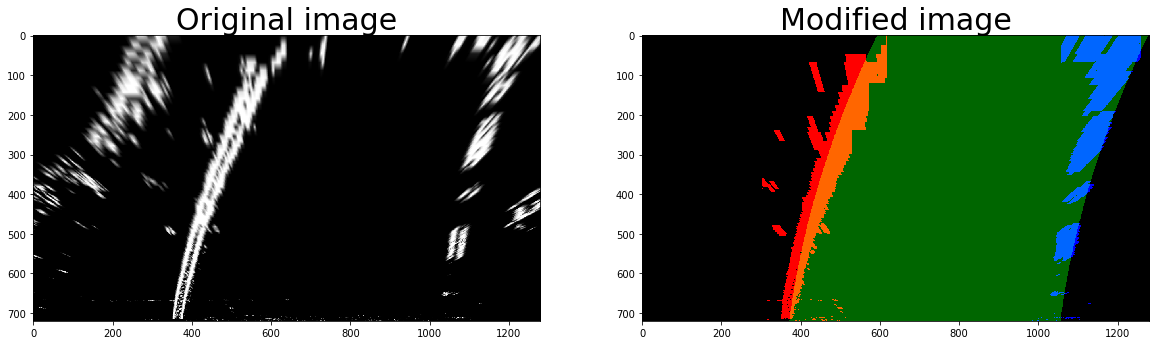

In [36]:
img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary = binary_image(img)
binary_warped, _ = birds_eye(binary, mtx, dist)
        
lane, left_fit, right_fit = lane_image(binary_warped, show_lane_pixels=True)
display_images(binary_warped, lane, cmap='gray')

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

In [13]:
def curvature(left_fit, right_fit, x_range=1280, y_range=720, 
              xm_per_pix=3.7/700, ym_per_pix = 30/720):
    '''
    ym_per_pix: meters per pixel in y dimension
    xm_per_pix: meters per pixel in x dimension
    '''
    ploty = np.linspace(0, y_range-1, num=y_range)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    camera_center = x_range/2
    lane_center = (right_fitx[-1] - left_fitx[-1])/2
    shift = (lane_center - camera_center) * xm_per_pix # shift in meters

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad, shift

In [37]:
left_curverad, right_curverad, shift = curvature(left_fit, right_fit)
# Now our radius of curvature is in meters
print('Cuvature left: {:.1f}m /'.format(left_curverad), 
      'Curvature right: {:.1f}m'.format(right_curverad),
      'Center shift: {:.1f}m'.format(shift))
# Example values: 632.1 m    626.2 m

Cuvature left: 666.5m / Curvature right: 666.5m Center shift: -1.6m


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

In [52]:
def find_lane(img, mtx, dist, left_fit=None, right_fit=None):
    
    binary = binary_image(img)
    binary_warped, M = birds_eye(binary, mtx, dist)
    lane, left_fit, right_fit = lane_image(binary_warped, left_fit=left_fit, right_fit=right_fit)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(lane, np.linalg.inv(M), (img.shape[1], img.shape[0]))
    
    if np.max(img) > 1:
        img = img/255.
        
    result = cv2.addWeighted(img.astype(np.float64), 1., newwarp, 0.3, 0)
    result[result > 1.] = 1.
    
    binary_small = cv2.resize(binary_warped, None, fx=.4, fy=.4, interpolation = cv2.INTER_CUBIC)
    binary_small = np.dstack((binary_small, binary_small, binary_small))
    result[:binary_small.shape[0], result.shape[1] - binary_small.shape[1]:] = binary_small
    
    left_curverad, right_curverad, shift = curvature(left_fit, right_fit)
    mean_curvature = np.mean((left_curverad, right_curverad))
    
    cv2.fillConvexPoly(result,np.array([(0,0),(0, binary_small.shape[0]-1),
                                        (800,binary_small.shape[0]-1),(800,0)]),(0,0,0)) 
    
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(result, 'Curvature: {:.01f}m'.format(mean_curvature), (50,80), font, 4, (1,1,1), 3)
    cv2.putText(result, 'Center shift: {:.01f}m'.format(shift), (50,150), font, 4, (1,1,1), 3)
    
    # Combine the result with the original image
    return result, left_fit, right_fit

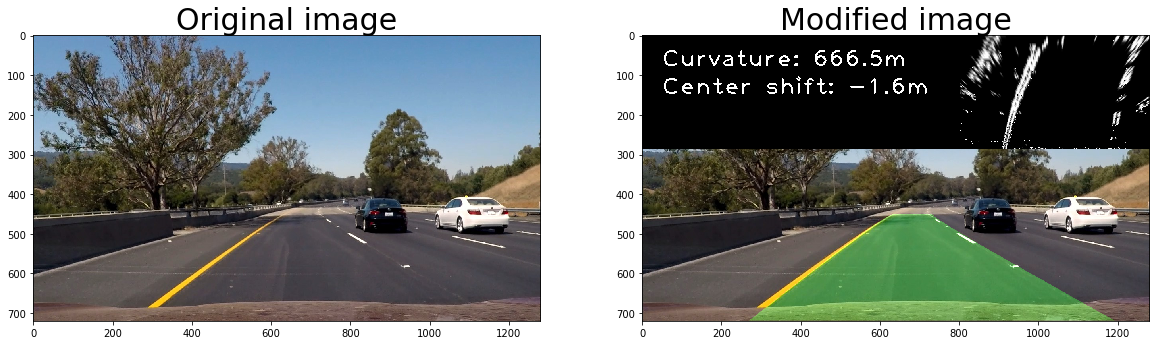

In [53]:
img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lane, lf, rf = find_lane(img, mtx, dist)
display_images(img, lane)

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

---

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [56]:
frame_count = 0
left_fit = None
right_fit = None
left_fits = []
right_fits = []
last_frame = None

def moving_average(a, n=20):
    
    if len(a) == 0:
        return None
    
    if len(a) < n:
        return a[-1]
    
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return (ret[n-1:] / n)[-1]

def smooth_fit(left_fit, right_fit, left_fits, right_fits):
    
    '''if len(left_fits) > 0 and len(right_fits) > 0:
        left_avg, right_avg = left_fits[-1], right_fits[-1]
    else:
        left_avg, right_avg = None, None
    
    if left_avg is not None and right_avg is not None:
        left_mse = np.sqrt(((left_fit - left_avg) ** 2)).mean(axis=0)
        right_mse = np.sqrt(((right_fit - right_avg) ** 2)).mean(axis=0)
    else:
        left_mse = 0
        right_mse = 0
    
    print(left_mse, right_mse)
    print(len(left_fits), len(right_fits))
    mse_thresh = 10.
    
    if left_mse < mse_thresh:
        left_fits.append(left_fit)
    
    if right_mse < mse_thresh:
        right_fits.append(right_fit)'''
        
    left_fits.append(left_fit)
    right_fits.append(right_fit)
        
    return moving_average(np.array(left_fits)), moving_average(np.array(right_fits))

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    #img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    global frame_count
    global left_fit
    global right_fit
    global left_fits
    global right_fits
    global last_frame
    
    frame_count += 1
    
    frame, left_fit, right_fit = find_lane(image, mtx, dist, left_fit=left_fit, right_fit=right_fit)
    left_fit, right_fit = smooth_fit(left_fit, right_fit, left_fits, right_fits)
    last_frame = frame*255
    return last_frame

In [58]:
clip = VideoFileClip('short.mp4')
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile('output.mp4', audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


  1%|▎                                         | 1/120 [00:00<00:43,  2.76it/s]


TypeError: a bytes-like object is required, not 'str'

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  